# Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains

- [Project Page](https://bmild.github.io/fourfeat/)

In [1]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def try_gpu(i=0):
    """ Return gpu(i) if exists, otherwise return cpu(). """
    if torch.cuda.is_available():
        print(f"GPU detected: {torch.cuda.get_device_name(i)}")
        return torch.device(f'cuda:{i}')
    else:
        print("No GPU detected, using CPU")
        return torch.device('cpu')

In [3]:
device = try_gpu()
print('Using device:', device)

GPU detected: NVIDIA T400 4GB
Using device: cuda:0


## Image Regression

In [4]:
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size, output_size, input_mapping_layer):
        super(MyMLP, self).__init__()

        # Input layer
        if input_mapping_layer != None:
            input_mapping_size = input_mapping_layer.get_output_size()
            self.name = 'MLP with ' + input_mapping_layer.get_name()
            self.layers = [input_mapping_layer, nn.Linear(input_mapping_size, hidden_size), nn.ReLU()]
        else:
            self.name = 'Standard MLP'
            self.layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])

        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

    def get_name(self):
        return self.name


In [5]:
image_path = '../../assets/images/fox.jpg'
image = Image.open(image_path)
min_side = min(image.size) - 32

transform = transforms.Compose([
    transforms.CenterCrop(min_side),
    transforms.Resize(128),
    transforms.ToTensor()
])

tensor_image = transform(image).permute(1, 2, 0)

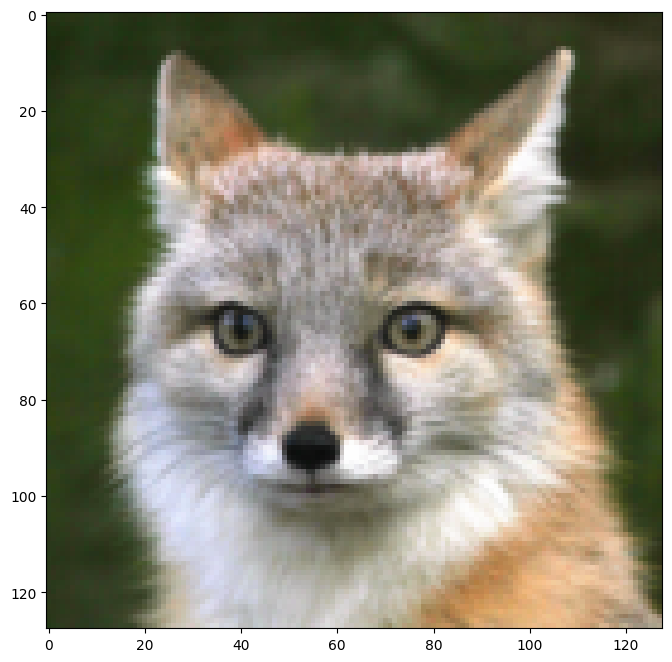

In [6]:
plt.figure(figsize=(8, 8))
plt.imshow(tensor_image)
plt.show()

In [7]:
tensor_image = tensor_image.to(device)

In [8]:
def get_line_of_rgb_values(img, y):
    return img[:, y]


def get_line_of_uv(y, width, height):
    u = torch.arange(0, width, dtype=torch.float32) / width
    v = torch.zeros(width, dtype=torch.float32).fill_(y / height)
    return torch.stack((u, v), dim=1).to(device)


In [10]:
def my_image_train(model, image, learning_rate, num_epochs):
    image_width = image.shape[0]
    image_height = image.shape[1]

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    model.train()
    model.to(device)

    for _ in tqdm(range(num_epochs), dynamic_ncols=True, desc=f'Training on {device}'):
        optimizer.zero_grad()

        for y in range(image_height):
            uv = get_line_of_uv(y, image_width, image_height)
            rgb = get_line_of_rgb_values(image, y)
            rgb_pred = model(uv)

            loss = loss_fn(rgb_pred, rgb)
            loss.backward()
            optimizer.step()

In [11]:
def xavier_init(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            init.xavier_normal_(layer.weight)

In [12]:
class BasicMappingLayer(nn.Module):
    def __init__(self, input_size):
        super(BasicMappingLayer, self).__init__()
        self.input_size = input_size

    def forward(self, v):
        v_proj = 2.0 * torch.pi * v
        return torch.cat([torch.cos(v_proj), torch.sin(v_proj)], dim=-1)

    def get_output_size(self):
        return self.input_size * 2

    def get_name(self):
        return 'basic mapping'

In [13]:
 class PositionalEncodingLayer(nn.Module):
    def __init__(self, input_size, mapping_size, scale):
        super(PositionalEncodingLayer, self).__init__()
        self.input_size = input_size
        self.mapping_size = mapping_size
        self.scale = scale

    def forward(self, x):
        rets = []
        m = self.mapping_size - 1
        for j in range(m):
            for fn in [torch.sin, torch.cos]:
                s = self.scale ** (j / m)
                rets.append(fn(2.0 * torch.pi * s * x))
        return torch.cat(rets, dim=-1)

    def get_output_size(self):
        m = self.mapping_size - 1
        return self.input_size * 2 * m

    def get_name(self):
        return 'positional encoding'

In [14]:
class GaussianFourierMappingLayer(nn.Module):
    def __init__(self, input_size, mapping_size, scale):
        super(GaussianFourierMappingLayer, self).__init__()
        self.input_size = input_size
        self.mapping_size = mapping_size
        self.B = nn.Parameter(torch.normal(mean=0, std=scale, size=(mapping_size, input_size)), requires_grad=True)
        self.scale = scale

    def forward(self, x):
        x_proj = (2.0 * torch.pi * x) @ self.B.T
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

    def get_output_size(self):
        return self.input_size * self.mapping_size

    def get_name(self):
        return f'Gaussian {self.scale}'

In [15]:
input_size = 2
hidden_layers = 8
hidden_size = 256
output_size = 3

mapping_size = 16
scale = 10

# Standard MLP
models = [MyMLP(input_size, hidden_layers, hidden_size, output_size, None)]

# Basic mapping
basic_input_mapping = BasicMappingLayer(input_size)
models.append(
    MyMLP(input_size, hidden_layers, hidden_size, output_size, basic_input_mapping)
)

# Positional encoding
positional_encoding = PositionalEncodingLayer(input_size, mapping_size, scale)
models.append(
    MyMLP(input_size, hidden_layers, hidden_size, output_size, positional_encoding)
)

# Fourier mapping
fourier_mapping = GaussianFourierMappingLayer(input_size, mapping_size, scale)
models.append(
    MyMLP(input_size, hidden_layers, hidden_size, output_size, fourier_mapping)
)

fourier_mapping = GaussianFourierMappingLayer(input_size, mapping_size, scale ** 2)
models.append(
    MyMLP(input_size, hidden_layers, hidden_size, output_size, fourier_mapping)
)

print(f'image size: ({tensor_image.shape[0]}, {tensor_image.shape[1]})')
for model in models:
    state_dict_file = f'state_dict/{model.get_name()}.pt'
    if os.path.isfile(state_dict_file):
        model.load_state_dict(torch.load(state_dict_file))
        model.to(device)
        print("Loaded state_dict from", state_dict_file)
    else:
        print('Model: ', model.get_name())
        model.apply(xavier_init)
        my_image_train(model, tensor_image, 1e-4, 2000)
        torch.save(model.state_dict(), state_dict_file)

image size: (128, 128)
Loaded state_dict from state_dict/Standard MLP.pt
Loaded state_dict from state_dict/MLP with basic mapping.pt
Loaded state_dict from state_dict/MLP with positional encoding.pt
Model:  MLP with Gaussian 10


Training on cuda:0:   0%|          | 0/2000 [00:00<?, ?it/s]

Model:  MLP with Gaussian 100


Training on cuda:0:   0%|          | 0/2000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


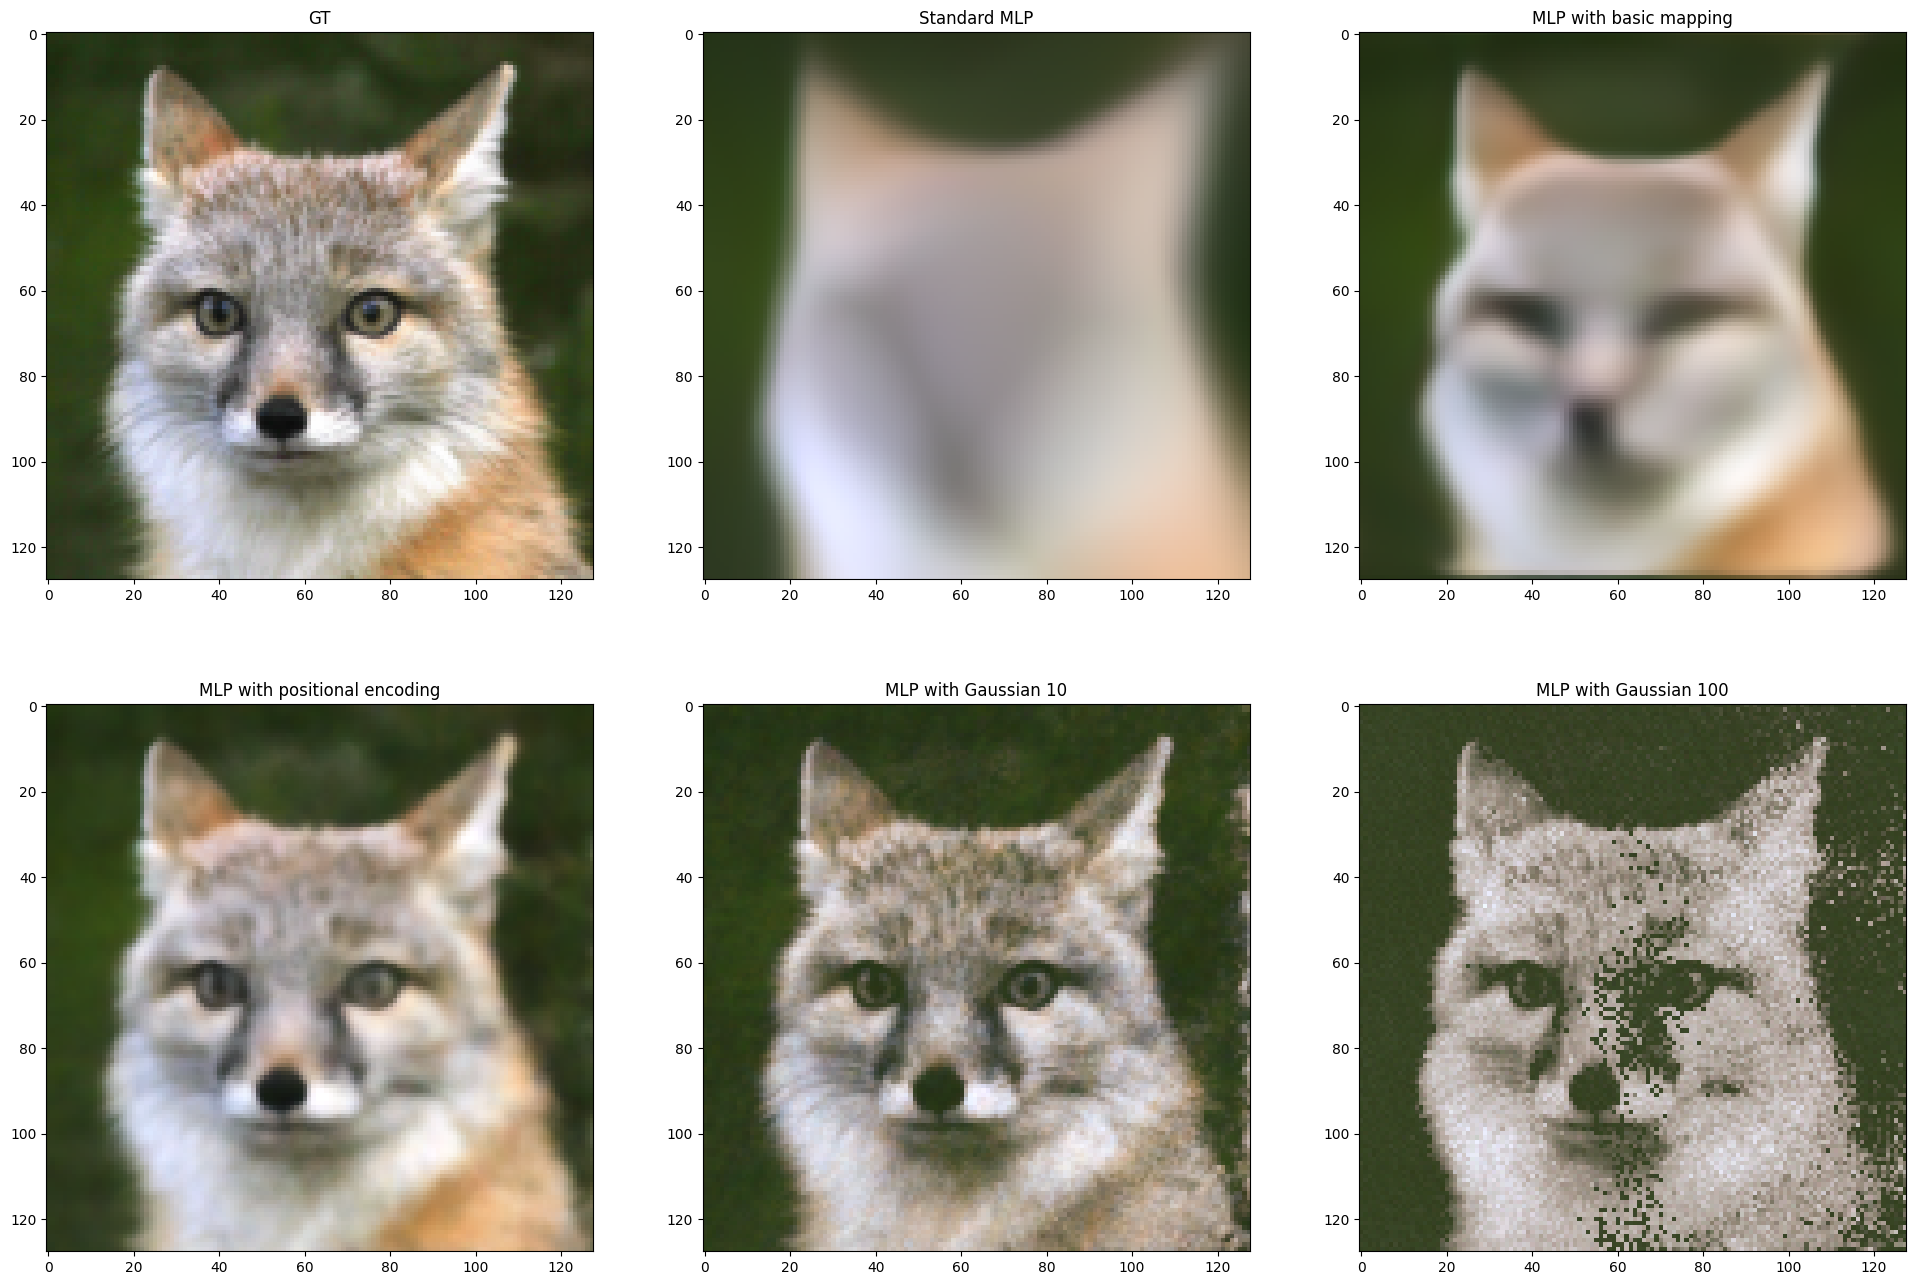

In [16]:
image_width = tensor_image.shape[0]
image_height = tensor_image.shape[1]
model_count = len(models)

nrows = 2
ncols = int(np.ceil((model_count + 1) / 2))

plt.figure(figsize=(8 * ncols, 8 * nrows))
plt.subplot(nrows, ncols, 1)
plt.title('GT')
plt.imshow(tensor_image.detach().cpu().numpy())

for i in range(model_count):
    model = models[i]
    model.eval()
    image_pred = torch.zeros_like(tensor_image)
    for y in range(image_height):
        uv = get_line_of_uv(y, image_width, image_height)
        rgb_pred = model(uv)
        image_pred[:, y] = rgb_pred

    plt.subplot(nrows, ncols, i + 2)
    plt.imshow(image_pred.detach().cpu().numpy())
    plt.title(model.get_name())

plt.savefig('plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [17]:
from torchsummary import summary

In [18]:
dummy_input = torch.tensor([0.1, 0.2]).to(device)
model = models[0]

In [19]:
summary(model, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]             768
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 256]          65,792
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 256]          65,792
              ReLU-8                  [-1, 256]               0
            Linear-9                  [-1, 256]          65,792
             ReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 256]          65,792
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 256]          65,792
             ReLU-14                  [